# Source boundary deviations, metrics, and distribution

In [1]:
# imports
import boundarytools
import numpy as np

import json
from urllib.request import urlopen

## Load in a set of country boundaries from different sources

In [168]:
# set params
country = 'CIV' #'TUN' #'BDI' #'BLR' #'LUX' #'CHE'
source1 = 'gadm'
source2 = 'naturalEarth'
source3 = 'CIV_CNTIG'
level = 1

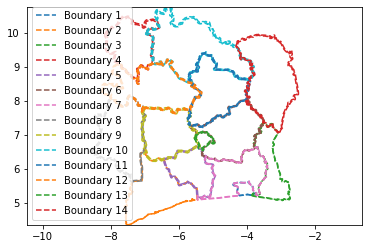

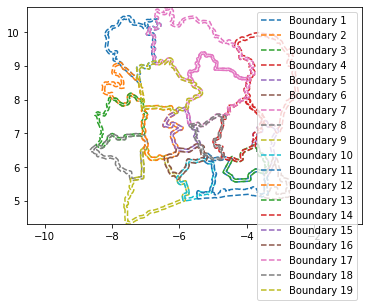

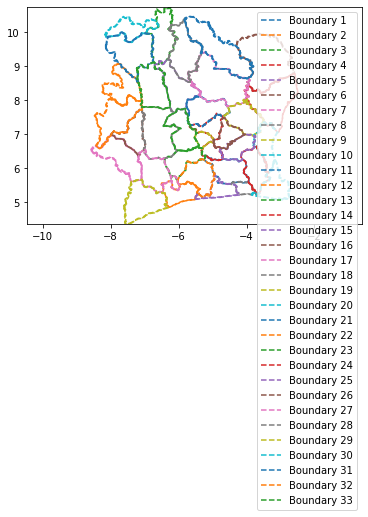

In [169]:
# load data
topoj1 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source1, level=level)).read())
coll1 = boundarytools.utils.topo2geoj(topoj1)
boundaries1 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll1['features']]
boundarytools.utils.show_boundaries(boundaries1)

topoj2 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source2, level=level)).read())
coll2 = boundarytools.utils.topo2geoj(topoj2)
boundaries2 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll2['features']]
boundarytools.utils.show_boundaries(boundaries2)

topoj3 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source3, level=level)).read())
coll3 = boundarytools.utils.topo2geoj(topoj3)
boundaries3 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll3['features']]
boundarytools.utils.show_boundaries(boundaries3)

## Calculate boundary deviations between sources for a given feat

source2


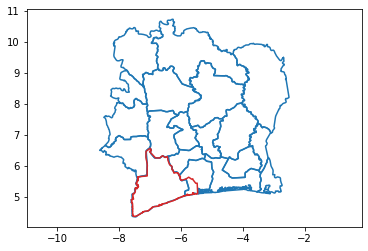

source3


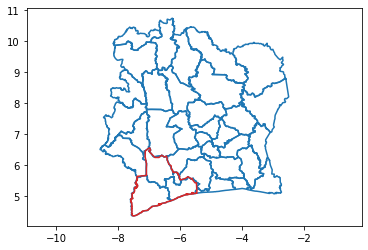

distances 2034
mean 0.0
stdev 0.030863664568279617


In [119]:
# params
SIGNED = False
feat_i = 1

# determine the feat
feat = coll1['features'][feat_i]

# convert source2 feats to multilinestring
geom2 = {'type':'MultiPolygon',
                   'coordinates':[[ring]
                                  for feat2 in coll2['features']
                                  for ring in boundarytools.utils.iter_rings(feat2['geometry'])
                                 #] + [[ring]
                                 #for feat3 in coll3['features']
                                 #for ring in boundarytools.utils.iter_rings(feat3['geometry'])
                                 ],
                  }
geom3 = {'type':'MultiPolygon',
                   'coordinates':[[ring]
                                  for feat3 in coll3['features']
                                  for ring in boundarytools.utils.iter_rings(feat3['geometry'])
                                 ],
                  }

# show
d1 = {'type':'FeatureCollection', 'features':[feat]}
d2 = {'type':'FeatureCollection', 'features':[{'type':'Feature','geometry':geom2}]}
d3 = {'type':'FeatureCollection', 'features':[{'type':'Feature','geometry':geom3}]}
print('source2')
boundarytools.utils.show_datasets(d2, d1)
print('source3')
boundarytools.utils.show_datasets(d3, d1)

# calc dists
dists2 = boundarytools.compare.boundary_distances(feat['geometry'], geom2, 0.01, signed_distances=SIGNED)
dists2 = np.array(dists2)
dists3 = boundarytools.compare.boundary_distances(feat['geometry'], geom3, 0.01, signed_distances=SIGNED)
dists3 = np.array(dists3)
dists = np.append(dists2, dists3)
print('distances', len(dists))

# fake the distribution to be +- around assumed mean of 0
if not SIGNED:
    dists = np.append(dists, -dists)
    
# calc mean and stdev of dists
print('mean', dists.mean())
print('stdev', dists.std())

## Plot

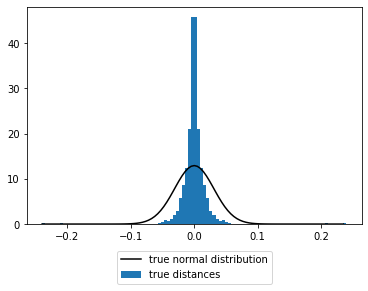

In [120]:
def plot():
    # first plot the true distance distribution
    import matplotlib.pyplot as plt
    ys,bins,patches = plt.hist(dists, bins=100, density=True, label='true distances') #, cumulative=True) #, range=(0,2e-09))
    xs = bins[:-1] # use only start of each bin as x value
    #plt.xscale('log')
    
    # add in normal dist
    import math
    def normpdf(x, mean, sd):
        var = float(sd)**2
        denom = (2*math.pi*var)**.5
        num = math.exp(-(float(x)-float(mean))**2/(2*var))
        return num/denom
    mean = dists.mean() # if we ignore the sign of the distances (ie no bias) this should be around 0
    std = dists.std()
    ypred = [normpdf(x, mean, std) for x in xs]
    plt.plot(xs, ypred, color='black', label='true normal distribution')

    # minimum line res
    #mean = 0
    #std = max(min1, min2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst minimum line res.)')
    
    # median line res
    #mean = 0
    #std = max(med1, med2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst median line res.)')
    
    # mean line res
    #mean = 0
    #std = max(mean1, mean2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst mean line res.)')
    
    # maximum line res
    #mean = 0
    #std = max(max1, max2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst maximum line res.)')
    
    # show
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    plt.show()
    
plot()

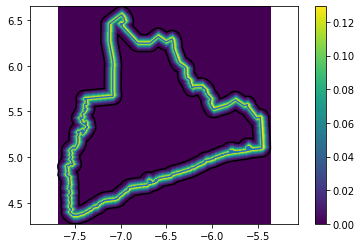

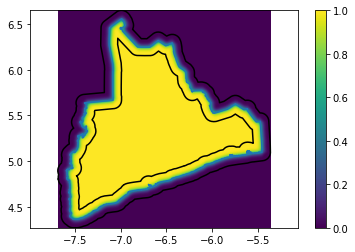

In [121]:
bnd = boundarytools.uncertainty.NormalBoundary(feat['geometry'], 
                                               mean=dists.mean(), stdev=dists.std())

bnd.show(surf=bnd.precision_surface(resolution=0.005))

bnd.show(surf=bnd.uncertainty_surface(resolution=0.005))

## Move into function

In [135]:
def create_boundary_from_dists(feat, feats, signed=False):
    # convert comparison feats to multilinestring
    geom2 = {'type':'MultiPolygon',
                       'coordinates':[[ring]
                                      for feat2 in feats
                                      for ring in boundarytools.utils.iter_rings(feat2['geometry'])
                                     ],
                      }

    # calc dists
    dists = boundarytools.compare.boundary_distances(feat['geometry'], geom2, 0.01, signed_distances=signed)
    dists = np.array(dists)

    # fake the distribution to be +- around assumed mean of 0
    if not signed:
        dists = np.append(dists, -dists)

    # calc mean and stdev of dists
    mean = dists.mean()
    stdev = dists.std()
    
    # create boundary
    bnd = boundarytools.uncertainty.NormalBoundary(feat['geometry'], mean=mean, stdev=stdev)
    
    return bnd,dists,mean,stdev

def plot(datas):
    import matplotlib.pyplot as plt
    import math
    def normpdf(x, mean, sd):
        var = float(sd)**2
        denom = (2*math.pi*var)**.5
        num = math.exp(-(float(x)-float(mean))**2/(2*var))
        return num/denom
    
    # add in normal distr for each data
    for key,data in datas.items():
        mean = data.mean() # if we ignore the sign of the distances (ie no bias) this should be around 0
        std = data.std()
        xs = np.linspace(data.min(), data.max(), 100)
        ypred = [normpdf(x, mean, std) for x in xs]
        plt.plot(xs, ypred, label=key)
    
    # show
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    plt.show()

## Create certainty surface for each feat, based on dists to all sources

In [172]:
def calc_boundaries_from_source_dists(mainsource, allsourcefeats, debug=False):
    otherfeats = allsourcefeats.copy()
    mainfeats = otherfeats.pop(mainsource)

    # loop each mainfeat
    boundaries = []
    for feat in mainfeats:
        if debug:
            print('--->', feat['properties'])
        datas = {}
        for sourcename,sourcefeats in otherfeats.items():
            bnd,dists,mean,stdev = create_boundary_from_dists(feat, sourcefeats)
            datas[sourcename] = dists

            # show
            if debug:
                print(sourcename, 'dists', len(dists))
                d1 = {'type':'FeatureCollection', 'features':[feat]}
                d2 = {'type':'FeatureCollection', 'features':sourcefeats}
                boundarytools.utils.show_datasets(d2, d1)

            # show each surface
            if debug:
                bnd.show(surf=bnd.precision_surface(resolution=0.005))

        # and finally the normal distr for all dists combined
        alldists = np.array([])
        for data in datas.values():
            alldists = np.append(alldists, data)
        datas['all sources'] = alldists
        bnd = boundarytools.uncertainty.NormalBoundary(feat['geometry'],
                                                      mean=alldists.mean(),
                                                      stdev=alldists.std())
        boundaries.append(bnd)

        # plot normal distributions
        if debug:
            plot(datas)
            
    return boundaries
    


### gadm


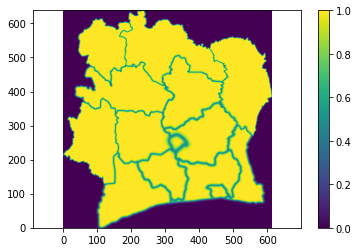

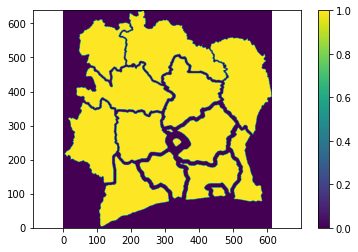

share of pixels that we can be highly certain (>0.95 probability) is within a particular boundary unit:
85.23%

### naturalEarth


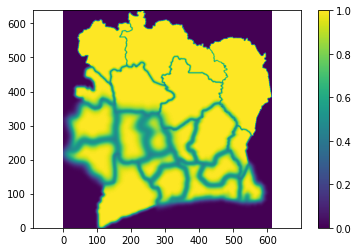

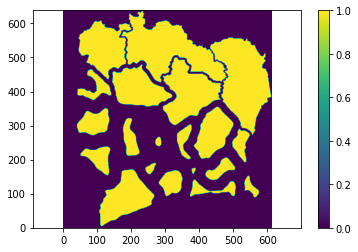

share of pixels that we can be highly certain (>0.95 probability) is within a particular boundary unit:
62.36%

### civ_cntig


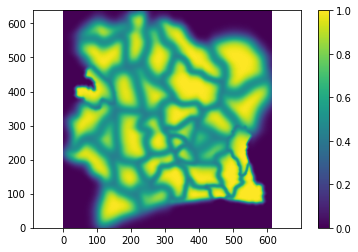

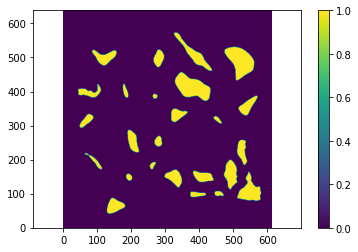

share of pixels that we can be highly certain (>0.95 probability) is within a particular boundary unit:
14.33%

### joint certainty across all sources


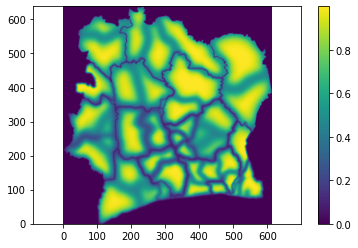

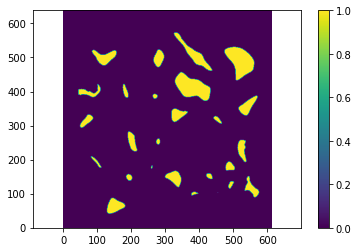

In [174]:
# params
res = 0.01
allsourcefeats = {
            'gadm':coll1['features'], 
            'naturalEarth':coll2['features'], 
            'civ_cntig':coll3['features'],
            }

# define common bbox for all comparisons
xs,ys = [],[]
for arc in topoj1['arcs']:
    _xs,_ys = zip(*arc)
    xs.extend(_xs)
    ys.extend(_ys)
bbox = min(xs),min(ys),max(xs),max(ys)

# loop from the perspective of each source
joint = None
for mainsource in allsourcefeats.keys():
    print('')
    print('###', mainsource)

    # calc the source boundaries based on the distance to the other sources
    boundaries = calc_boundaries_from_source_dists(mainsource, allsourcefeats) #, debug=True)

    # plot the final certainty surface for entire dataset
    cert = boundarytools.uncertainty.probability_inside(boundaries, resolution=res, bbox=bbox)
    boundarytools.utils.show_surface(cert)
    
    # update the joint probability surface across all source (ie that all agree)
    joint = cert if joint is None else joint * cert

    # high certainty
    # ie share of pixels above 0.95 certainty (not weighted, each pixel is 0/1 above or below threshold)
    perfectcert = boundarytools.uncertainty.crisp_footprints(boundaries, resolution=res, bbox=bbox)
    highcert = np.where(cert >= 0.95, 1, 0)
    boundarytools.utils.show_surface(highcert)
    perc = highcert.sum() / perfectcert.sum() * 100
    print('share of pixels that we can be highly certain (>0.95 probability) is within a particular boundary unit:')
    print('{:.2f}%'.format(perc))
    
# finally show the joint prob across sources
print('')
print('### joint certainty across all sources')
boundarytools.utils.show_surface(joint)

# high certainty of joint
highcert = np.where(joint >= 0.95, 1, 0)
boundarytools.utils.show_surface(highcert)